## RAG pipeline using NVIDIA AI Endpoints for LangChain. 

First, you create a vector store by downloading web pages and generating their embeddings using the NVIDIA NeMo Retriever embedding microservice and searching for similarity using FAISS. 

This is an improved version I have updated from NIVIDIA LangChain code example. So that this code can run on your local system without any issue.

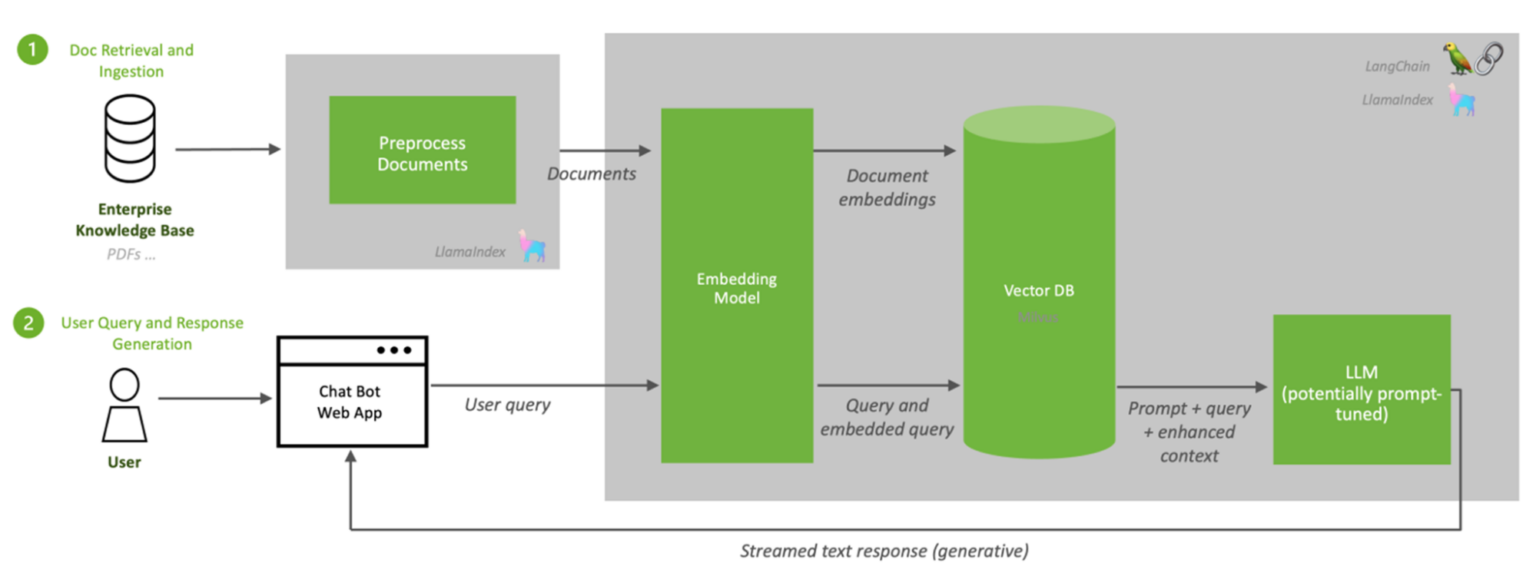

In [52]:
# !pip install langchain
# !pip install langchain_nvidia_ai_endpoints
# !pip install faiss-cpu

In [67]:
import os
from dotenv import load_dotenv
import openai
import re
from typing import List, Union
import requests
from bs4 import BeautifulSoup
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT, QA_PROMPT
from langchain.chains.question_answering import load_qa_chain
from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

# Include the NVIDIA API key
load_dotenv()
nvidia_api_key = os.environ.get("NVIDIA_API_KEY")

client = openai.OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = nvidia_api_key
)
print(client)

In [68]:
# import getpass

# if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
#     nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
#     assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
#     os.environ["NVIDIA_API_KEY"] = nvapi_key

In [69]:
model_name = "microsoft/phi-3-mini-128k-instruct"
llm = ChatNVIDIA(model=model_name, max_tokens=1000)

In [70]:
result = llm.invoke("What interfaces does Triton support?")
print(result.content)

Triton supports a variety of interfaces to ensure broad compatibility and ease of use. These interfaces include:


1. **Command Line Interface (CLI)**: Triton provides a CLI for users who prefer interacting with the system through text-based commands. This is particularly useful for scripting and automation tasks.


2. **Graphical User Interface (GUI)**: For users who prefer a visual approach, Triton offers a GUI. This interface allows users to interact with the system through graphical elements like windows, icons, and buttons.


3. **APIs**: Triton exposes a set of Application Programming Interfaces (APIs) that allow developers to create custom applications or integrate Triton's functionalities into their own software.


4. **Web Interface**: Triton also offers a web-based interface, which can be accessed through a web browser. This makes it possible to manage Triton's features remotely and is particularly useful for cloud-based deployments.


5. **Plug-ins and Extensions**: To exten

In [71]:
result = llm.invoke("What interfaces does NVIDIA Triton support?")
print(result.content)

NVIDIA Triton, formerly known as the Inference Server for TensorFlow, supports a variety of interfaces to facilitate the deployment of machine learning models. The primary interfaces include:

1. **HTTP/HTTPS**: This is the most common interface for serving machine learning models. It allows clients to send requests over the web and receive predictions in response.

2. **gRPC**: This interface is designed for high-performance, low-latency communication. It uses Protocol Buffers as its interface definition language and is particularly useful for microservices architectures.

3. **TensorFlow Serving**: While Triton itself is a standalone server, it can also serve as an alternative to TensorFlow Serving for deploying models. It provides a flexible and efficient way to serve models, especially when integrated with Triton.

4. **Custom Interfaces**: NVIDIA Triton supports custom interfaces, allowing developers to define their own protocols for model serving. This can be useful for integrati

In [72]:
result = llm.invoke("But why?")
print(result.content)

The reason for this is to ensure that the data is not corrupted or lost. When you delete a file, it's not immediately removed from the storage device. Instead, the space it occupied is marked as available for reuse. Until that space is overwritten by new data, the original data can potentially be recovered. This is why it's often recommended to use a reliable method to permanently delete files, especially those containing sensitive information.


In [73]:
embedding_model = NVIDIAEmbeddings(allow_dangerous_deserialization=True, model="ai-embed-qa-4")

docsearch = FAISS.load_local(allow_dangerous_deserialization=True, folder_path=embedding_path, embeddings=embedding_model)


C:\Users\dhira\anaconda3\Lib\site-packages\langchain_nvidia_ai_endpoints\_statics.py:361: UserWarning: Model ai-embed-qa-4 is deprecated. Using NV-Embed-QA instead.
  warnings.warn(


In [74]:
def html_document_loader(url: Union[str, bytes]) -> str:
    """
    Loads the HTML content of a document from a given URL and return it's content.

    Args:
        url: The URL of the document.

    Returns:
        The content of the document.

    Raises:
        Exception: If there is an error while making the HTTP request.

    """
    try:
        response = requests.get(url)
        html_content = response.text
    except Exception as e:
        print(f"Failed to load {url} due to exception {e}")
        return ""

    try:
        # Create a Beautiful Soup object to parse html
        soup = BeautifulSoup(html_content, "html.parser")

        # Remove script and style tags
        for script in soup(["script", "style"]):
            script.extract()

        # Get the plain text from the HTML document
        text = soup.get_text()

        # Remove excess whitespace and newlines
        text = re.sub("\s+", " ", text).strip()

        return text
    except Exception as e:
        print(f"Exception {e} while loading document")
        return ""

In [75]:
def create_embeddings(embedding_path: str = "./embed"):

    embedding_path = "./embed"
    print(f"Storing embeddings to {embedding_path}")

    # List of web pages containing NVIDIA Triton technical documentation
    urls = [
         "https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/index.html",
         "https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/getting_started/quickstart.html",
         "https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_repository.html",
         "https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_analyzer.html",
         "https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/architecture.html",
    ]

    documents = []
    for url in urls:
        document = html_document_loader(url)
        documents.append(document)


    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=0,
        length_function=len,
    )
    texts = text_splitter.create_documents(documents)
    index_docs(url, text_splitter, texts, embedding_path)
    print("Generated embedding successfully")

In [76]:
def index_docs(url: Union[str, bytes], splitter, documents: List[str], dest_embed_dir, embedding_model=embedding_model, docsearch=docsearch) -> None:
    """
    Split the document into chunks and create embeddings for the document

    Args:
        url: Source url for the document.
        splitter: Splitter used to split the document
        documents: list of documents whose embeddings needs to be created
        dest_embed_dir: destination directory for embeddings

    Returns:
        None
    """

    for document in documents:
        texts = splitter.split_text(document.page_content)

        # metadata to attach to document
        metadatas = [document.metadata]

        # create embeddings and add to vector store
        if os.path.exists(dest_embed_dir):
            update = FAISS.load_local(allow_dangerous_deserialization=True, folder_path=dest_embed_dir, embeddings=embedding_model)
            update.add_texts(texts, metadatas=metadatas)
            update.save_local(folder_path=dest_embed_dir)
        else:
            docsearch.save_local(folder_path=dest_embed_dir)

In [77]:
create_embeddings()


Storing embeddings to ./embed
Generated embedding successfully


In [78]:
# Embed documents
embedding_path = "embed/"


In [79]:
llm = ChatNVIDIA(model=model_name)

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

question_generator = LLMChain(llm=llm, prompt=CONDENSE_QUESTION_PROMPT)

chat = ChatNVIDIA(model="mixtral_8x7b", temperature=0.1, max_tokens=1000, top_p=1.0)

doc_chain = load_qa_chain(chat , chain_type="stuff", prompt=QA_PROMPT)

qa = ConversationalRetrievalChain(
    retriever=docsearch.as_retriever(),
    combine_docs_chain=doc_chain,
    memory=memory,
    question_generator=question_generator,
)

C:\Users\dhira\anaconda3\Lib\site-packages\langchain_nvidia_ai_endpoints\_statics.py:361: UserWarning: Model mixtral_8x7b is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(


In [80]:
query = "What is Triton?"
result = qa({"question": query})
print(result.get("answer"))

 Triton, also known as NVIDIA Triton Inference Server, is an open-source inference serving software developed by NVIDIA. It is designed to streamline AI inferencing by enabling teams to deploy AI models from multiple deep learning and machine learning frameworks, such as TensorRT, TensorFlow, PyTorch, ONNX, OpenVINO, Python, and RAPIDS FIL, among others. Triton supports inference across various devices, including NVIDIA GPUs, x86 and ARM CPUs, or AWS Inferentia. It delivers optimized performance for various query types, including real-time, batched, ensembles, and audio/video streaming. Triton is part of NVIDIA AI Enterprise, a software platform that accelerates the data science pipeline and streamlines the development and deployment of production AI.


In [81]:
query = "What interfaces does Triton support?"
result = qa({"question": query})
print(result.get("answer"))

 Based on the provided context, the Triton Inference Server supports the following interfaces:

1. HTTP/REST: This is a stateless, client-server protocol that is widely used for web-based applications. It uses simple HTTP methods like GET and POST to communicate.

2. gRPC: This is an open-source high-performance remote procedure call (RPC) framework. It can run in any environment and enables client and server applications to communicate transparently.

3. C API: This is a C language interface that allows Triton to link directly into your application for edge and other in-process use cases.

4. Java API: This is a Java language interface that allows Triton to link directly into your Java application for edge and other in-process use cases.

Please note that these interfaces are used for making inference requests to the Triton Inference Server.


In [82]:
query = "But why?"
result = qa({"question": query})
print(result.get("answer"))

 Triton Inference Server supports multiple interfaces such as HTTP/REST, gRPC, C API, and Java API to provide flexibility and ease of integration for users. Different interfaces cater to various use cases and preferences:

1. HTTP/REST and gRPC: These interfaces are commonly used for communication between microservices and are widely supported across many programming languages. They enable integration with existing systems and allow for easy development of custom clients.

2. C API: The C API enables Triton to be linked directly into a user's application for edge and other in-process use cases. This can lead to better performance and lower latency since it avoids the need for network communication.

3. Java API: The Java API support allows Triton to be easily integrated into Java-based applications and systems. Java is a popular language for enterprise applications, so this interface simplifies adoption in such environments.

By providing multiple interfaces, Triton Inference Server in

In [83]:
llm = ChatNVIDIA(model=model_name, temperature=0.1, max_tokens=1000, top_p=1.0)

qa_prompt=QA_PROMPT

doc_chain = load_qa_chain(llm, chain_type="stuff", prompt=QA_PROMPT)

qa = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=docsearch.as_retriever(),
    chain_type="stuff",
    memory=memory,
    combine_docs_chain_kwargs={'prompt': qa_prompt},
)

In [84]:
query = "What is Triton?"
result = qa({"question": query})
print(result.get("answer"))

Triton, developed by NVIDIA, is an open-source inference serving software that offers several features and capabilities:

1. Supports multiple deep learning and machine learning frameworks such as TensorRT, TensorFlow, PyTorch, ONNX, OpenVINO, Python, RAPIDS FIL, and more.

2. Provides concurrent model execution, dynamic batching, and sequence batching with implicit state management for stateful models.

3. Offers a Backend API for adding custom backends and pre/post processing operations.

4. Allows model pipelines to be built using Ensembling or Business Logic Scripting (BLS).

5. Supports HTTP/REST and GRPC inference protocols based on the community-developed KServe protocol.

6. Includes a C API and Java API for direct integration into applications for edge and other in-process use cases.

7. Provides metrics indicating GPU utilization, server throughput, server latency, and more.

8. Offers enterprise support through NVIDIA global support for the NVIDIA AI Enterprise software suit

In [85]:
query = "Does Triton support ONNX?"
result = qa({"question": query})
print(result.get("answer"))

Yes, Triton supports ONNX models for inference. It is capable of deploying any AI model from multiple deep learning and machine learning frameworks, which includes ONNX. Triton's inference serving software is designed to streamline AI inferencing, and it supports ONNX models as long as they are compatible with the version of ONNX Runtime being used by Triton.


In [86]:
query = "But why?"
result = qa({"question": query})
print(result.get("answer"))

Triton supports ONNX models for inference because ONNX is a widely-used open format for representing machine learning models. It is supported by various deep learning frameworks, making it a versatile choice for deploying models. Triton's ability to serve models from multiple frameworks, including ONNX, allows for flexibility and broad compatibility in AI inferencing tasks.
